# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
![kaggle1.png](attachment:kaggle1.png)
![kaggle2.png](attachment:kaggle2.png)
2. Scroll down to API and click Create New API Token.
![kaggle3.png](attachment:kaggle3.png)
![kaggle4.png](attachment:kaggle4.png)
3. Open up `kaggle.json` and use the username and key.
![kaggle5.png](attachment:kaggle5.png)

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [ ]:
# for privacy, upload your kaggle.json file
# using google colab

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
![kaggle6.png](attachment:kaggle6.png)

#### upload and move the kaggle.json api key to
**/home/sagemaker-user/.kaggle/**
#### for being able to use it

In [3]:
# !mv kaggle.json /home/sagemaker-user/.kaggle/
# !chmod 600 /home/sagemaker-user/.kaggle/kaggle.json

#### Download the dataset

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import json
import pandas as pd
from autogluon.tabular import TabularPredictor

In [3]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.shape

(10886, 12)

In [5]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [6]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
test.shape

(6493, 9)

In [8]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [9]:
submission.shape

(6493, 2)

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
predictor = TabularPredictor(label = 'count',
                             eval_metric='root_mean_squared_error',
                             learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(
                                 train_data = train,
                                 time_limit=600,
                                 presets='best_quality')

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
# def save_predictors(pred_summary, fname='name'):
#     with open(fname + '.json', 'w') as f:
#         try:
#             json.dump(pred_summary, f, indent=4)
#         except:
#             pass

In [11]:
def save_predictors(pred_summary, fname='name'):
    with open(fname + '.txt', 'w') as f:
        f.write(str(pred_summary))

In [ ]:
save_predictors(predictor.fit_summary(), 'predictor')

### Create predictions from test dataset

In [13]:
predictions = predictor.predict(test)
predictions.head()

0    23.885902
1    43.061493
2    46.593201
3    49.502834
4    52.042191
Name: count, dtype: float32

In [14]:
# model evaluation
predictor.evaluate(pd.concat([test, predictions], axis=1))

{'root_mean_squared_error': -0.0,
 'mean_squared_error': -0.0,
 'mean_absolute_error': -0.0,
 'r2': 1.0,
 'pearsonr': 0.9999999999999999,
 'median_absolute_error': -0.0}

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [25]:
# Describe the predictions series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.598503
std        89.919060
min         3.245420
25%        19.936172
50%        63.877274
75%       168.192657
max       367.250488
Name: count, dtype: float64

In [26]:
# How many negative values do we have?
len(predictions[predictions < 0])

0

In [27]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [28]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [29]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 768kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [30]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-05-01 16:39:01  first raw submission               complete  1.80236      1.80236       
submission_new_hpo.csv       2024-05-01 15:20:27  new features with hyperparameters  complete  0.5217       0.5217        
submission_new_features.csv  2024-05-01 15:11:01  new features                       complete  0.4949       0.4949        
submission.csv               2024-05-01 14:56:48  first raw submission               complete  1.84669      1.84669       


#### Initial score of 1.80236

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

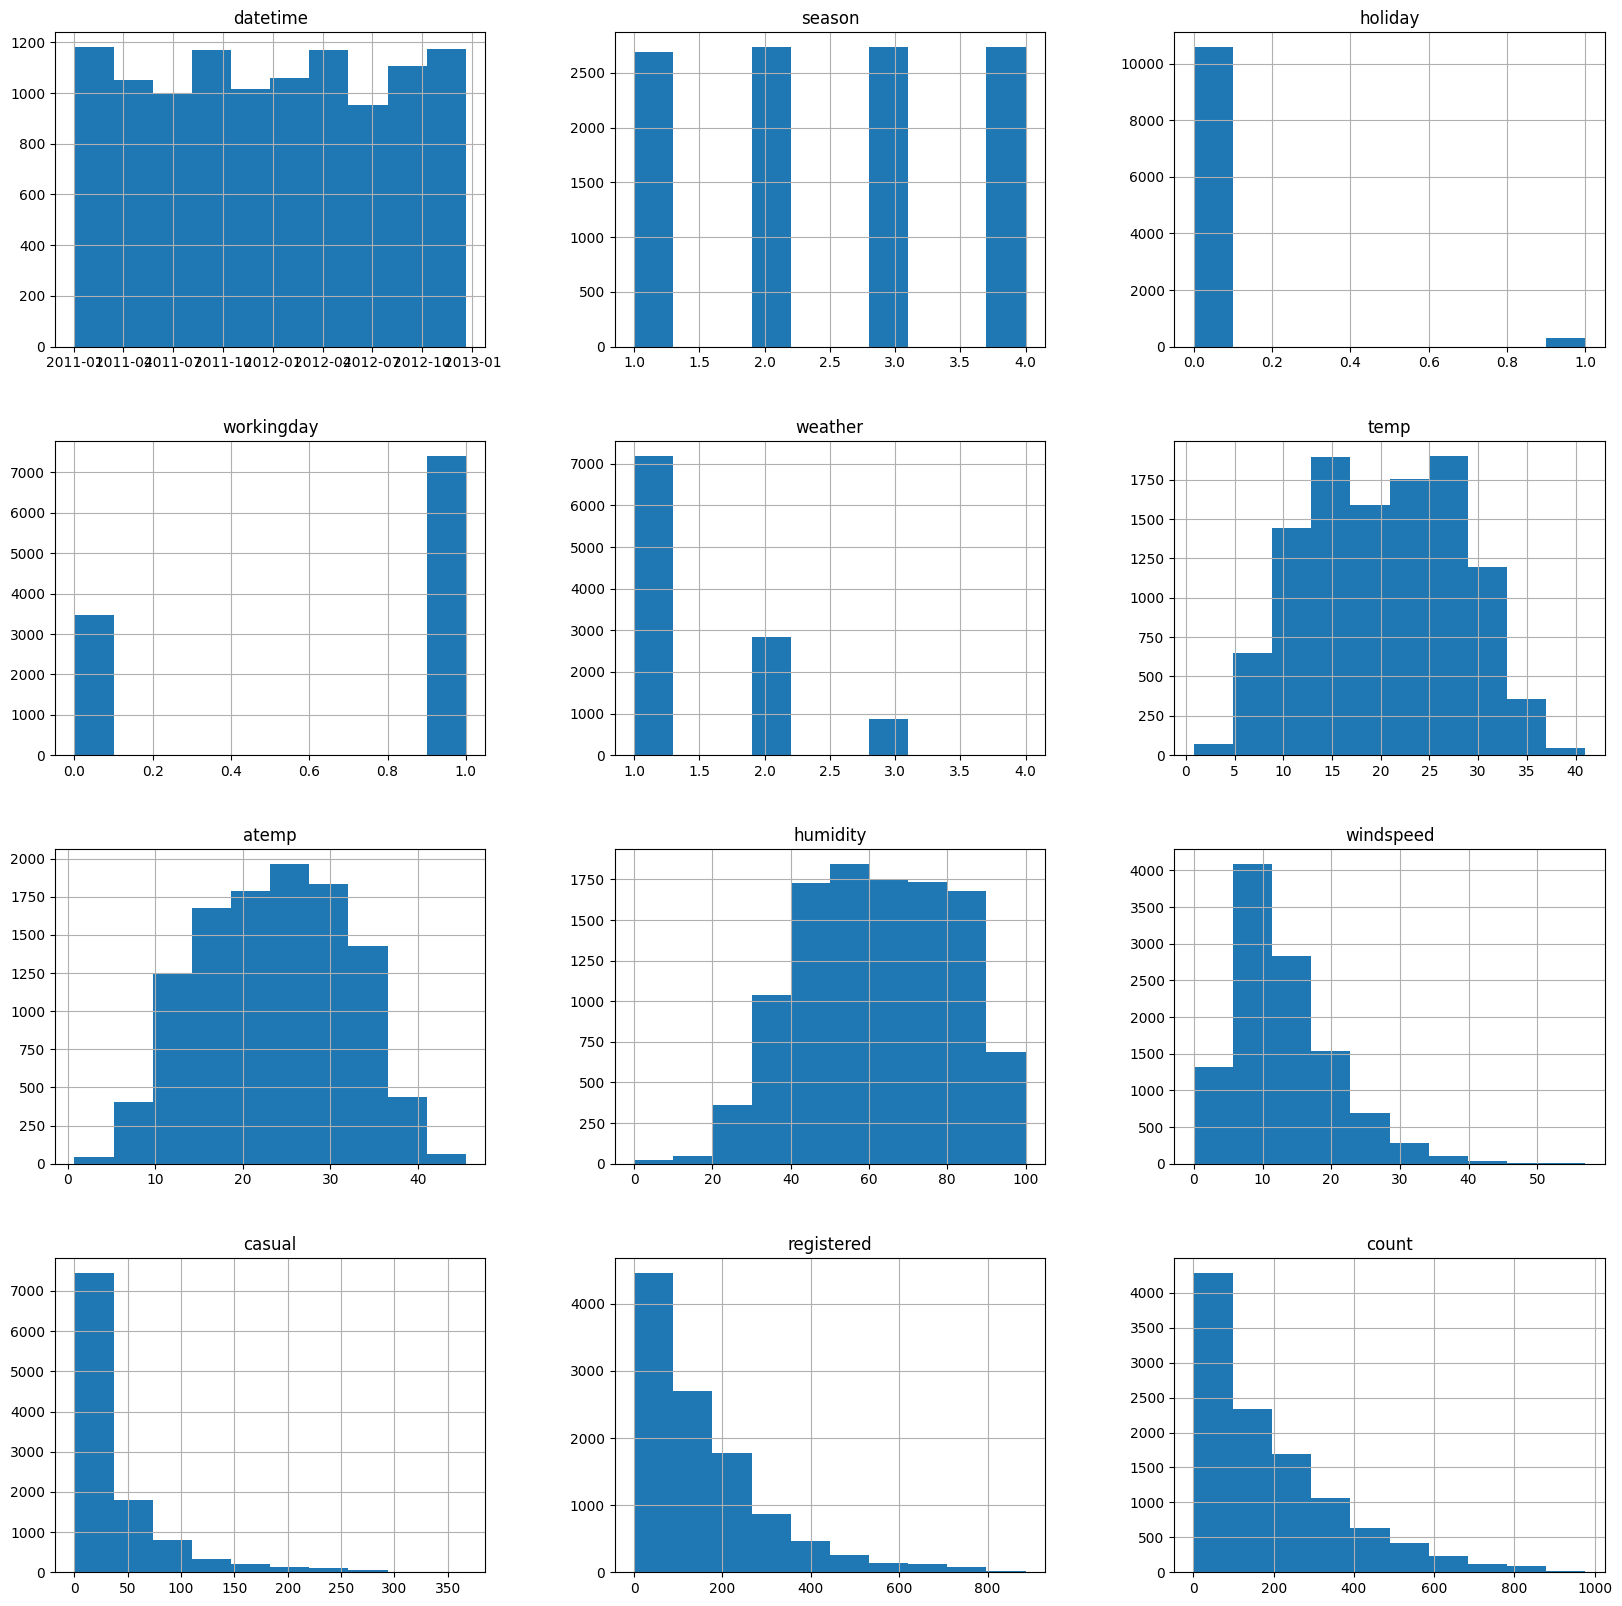

In [31]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20,20));

In [32]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train.drop(["datetime"], axis=1, inplace=True)

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test.drop(["datetime"], axis=1, inplace=True)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [34]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [35]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


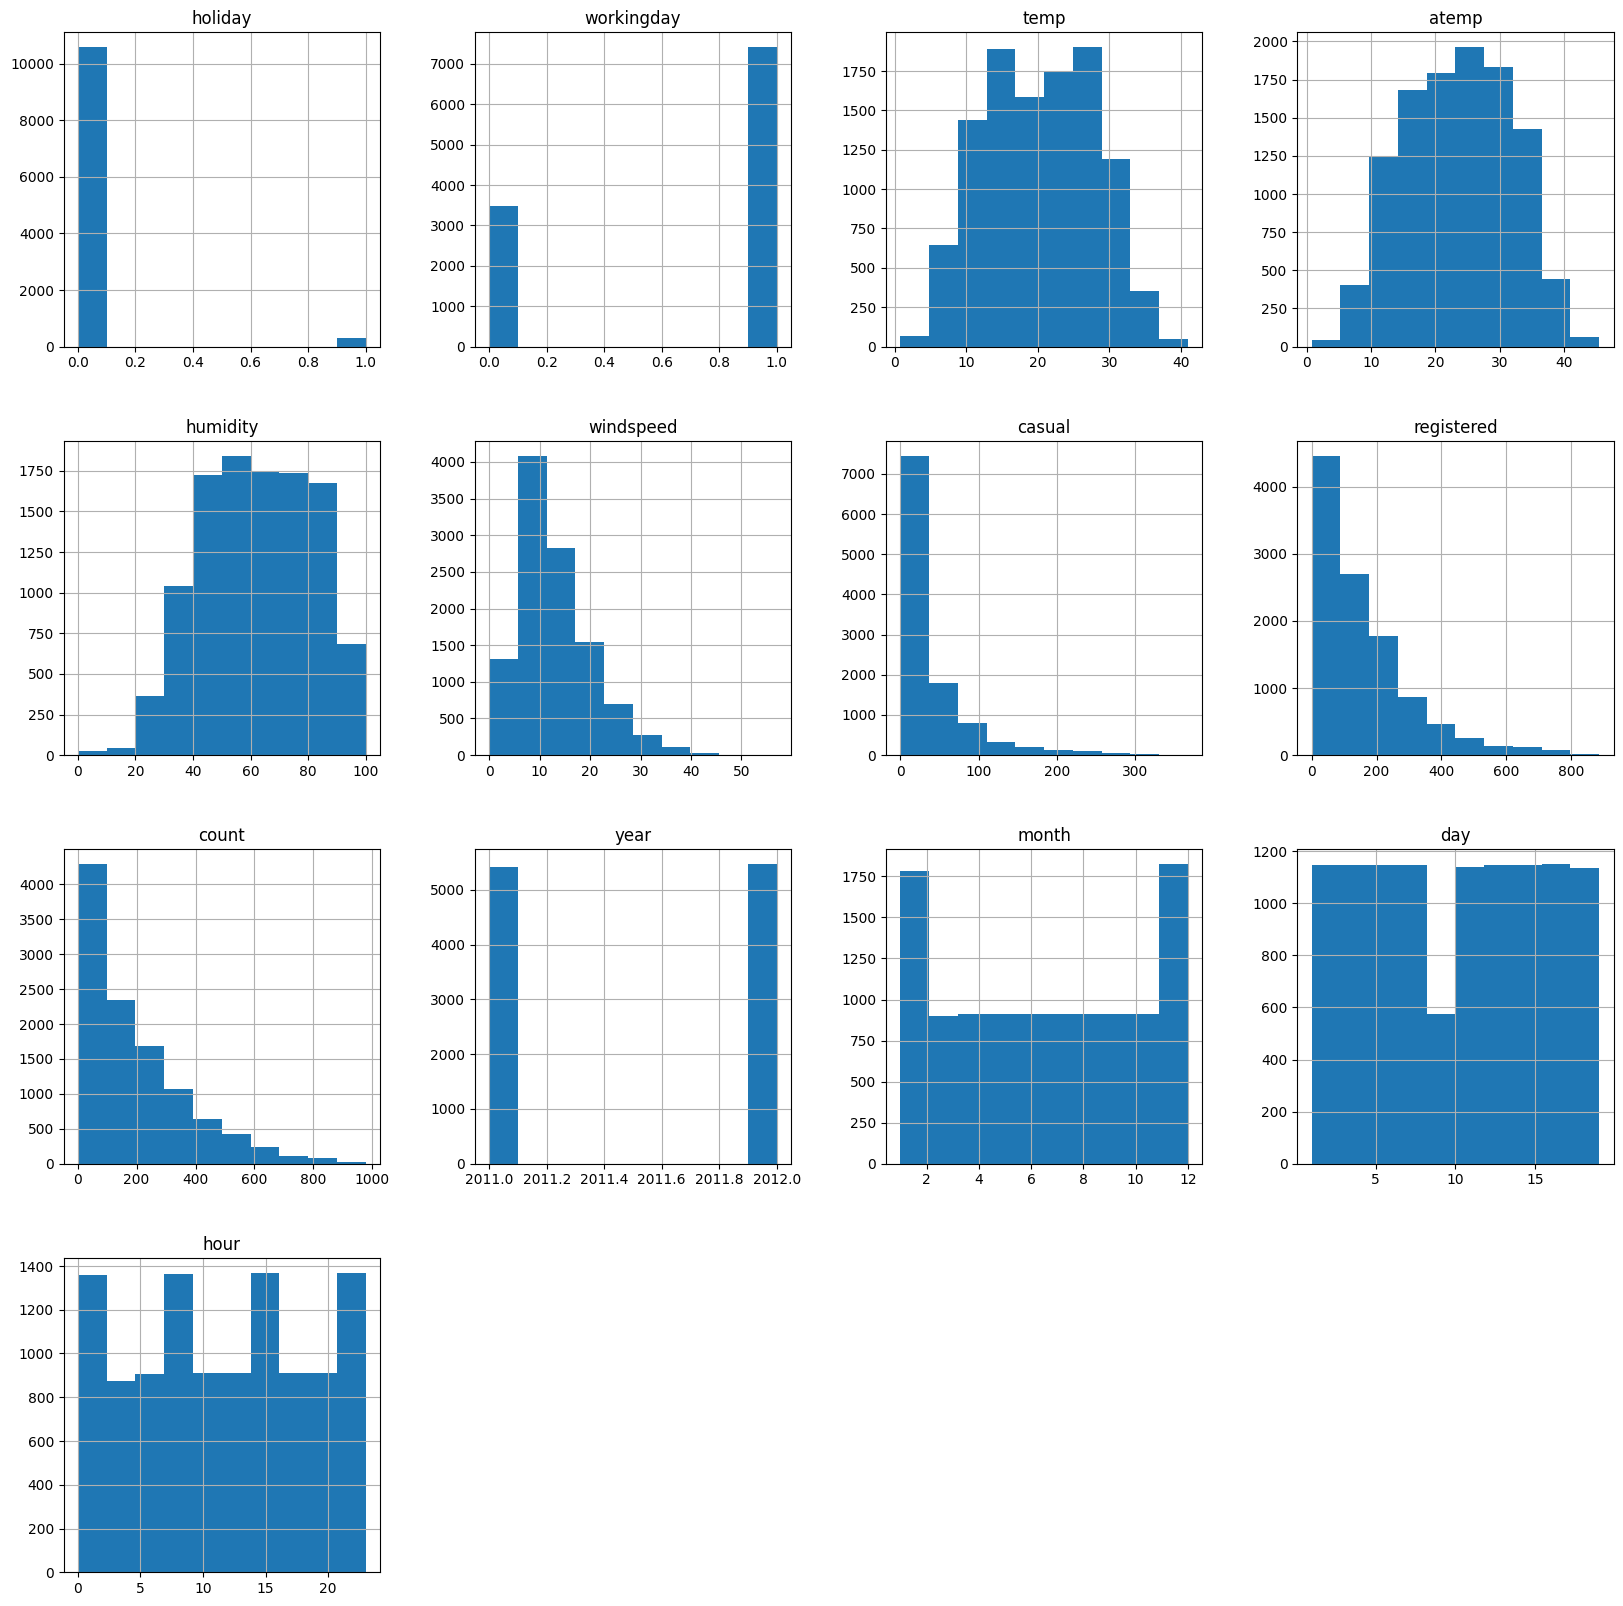

In [36]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(20,20));

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(label='count',
                                          eval_metric='root_mean_squared_error',
                                          learner_kwargs={"ignored_columns":['casual', 'registered']},
                                          ).fit(train_data=train,
                                                time_limit=600,
                                                presets='best_quality')

In [ ]:
save_predictors(predictor_new_features.fit_summary(), 'predictor_new_features')

In [39]:
new_features_predictions = predictor_new_features.predict(test)
new_features_predictions.head()

0    13.871695
1     4.048447
2     2.968997
3     4.407485
4     3.782836
Name: count, dtype: float32

In [41]:
# model evaluation
predictor_new_features.evaluate(pd.concat([test, new_features_predictions], axis=1))

{'root_mean_squared_error': -0.0,
 'mean_squared_error': -0.0,
 'mean_absolute_error': -0.0,
 'r2': 1.0,
 'pearsonr': 1.0,
 'median_absolute_error': -0.0}

In [42]:
len(new_features_predictions[new_features_predictions < 0])

17

In [43]:
# Remember to set all negative values to zero
new_features_predictions[new_features_predictions < 0] = 0

In [44]:
# Same submitting predictions
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features["count"] = new_features_predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [45]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:00<00:00, 633kB/s]
Successfully submitted to Bike Sharing Demand

In [46]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-05-01 17:03:15  new features                       complete  0.48698      0.48698       
submission.csv               2024-05-01 16:39:01  first raw submission               complete  1.80236      1.80236       
submission_new_hpo.csv       2024-05-01 15:20:27  new features with hyperparameters  complete  0.5217       0.5217        
submission_new_features.csv  2024-05-01 15:11:01  new features                       complete  0.4949       0.4949        


#### New Score of 0.48698

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [39]:
# !pip install ray
# from ray import tune

# # Define search space for hyperparameters
# hyperparameters = {
#     'num_epochs': tune.choice([10, 20, 30]),
#     'learning_rate': tune.uniform(1e-4, 1e-2),
#     'activation': tune.choice(['relu', 'softrelu', 'tanh']),
#     'layers': tune.choice([[100], [200, 100], [300, 200, 100]]),
#     'dropout_prob': tune.uniform(0.0, 0.5),
# }

# # Define hyperparameter tuning configuration for Ray Tune
# hyperparameter_tune_kwargs = {
#     "num_samples": 10,
#     "config": hyperparameters,
#     "metric": "root_mean_squared_error",
#     "mode": "min",
# }

In [88]:
# import autogluon.common as ag

# nn_options = {
#     'num_epochs': 5,
#     'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
#     'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
#     'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)
# }

# gbm_options = [
#     {
#         'extra_trees': True,
#         'num_boost_round': ag.space.Int(lower=100, upper=500, default=100),
#         'num_leaves': ag.space.Int(lower=25, upper=64, default=36),
#         'ag_args': {'name_suffix': 'XT'}
#     },
#     {},
#     'GBMLarge'
# ]

# hyperparameters = {
#     'GBM': gbm_options,
#     'NN_TORCH': nn_options,
# }

# num_trials = 20
# search_strategy = 'auto'
# scheduler = 'local'

# hyperparameter_tune_kwargs = {
#     'num_trials': num_trials,
#     'scheduler': scheduler,
#     'searcher': search_strategy,
# }

In [ ]:
import autogluon.common as ag

# Random forest, KNN, and NN give errors in autogluon and eventually autogluon skips them
xgb_options = {
    'n_estimators': ag.space.Int(lower=100, upper=400, default=100),
    'max_depth': ag.space.Int(lower=4, upper=12, default=6),       # Maximum depth of each tree (default is 6)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)
}

cat_options = {
    'iterations' : 100,
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'depth' : ag.space.Int(lower=6, upper=10)
}


gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36)  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {'XGB': xgb_options,
                   'CAT': cat_options,
                   'GBM': gbm_options}
num_trials = 5
search_strategy = 'random' # try 'skopt' too ... (gives an error)

hyperparameter_tune_kwargs = {'num_trials' : num_trials,
                              'scheduler' : 'local',
                              'searcher' : search_strategy}

In [ ]:
predictor_new_hpo = TabularPredictor(label = 'count',
                                     eval_metric = 'root_mean_squared_error',
                                     learner_kwargs = {"ignored_columns": ['casual', 'registered']}).fit(
                                         train_data = train,
                                         time_limit = 600,
                                         presets = 'best_quality',
                                         hyperparameters=hyperparameters,
                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

In [ ]:
save_predictors(predictor_new_hpo.fit_summary(), 'predictor_new_hpo')

In [91]:
# make predictions on the hpo model
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    9.948826
1    7.106323
2    6.406781
3    6.380059
4    6.380059
Name: count, dtype: float32

In [92]:
# model evaluation
predictor_new_hpo.evaluate(pd.concat([test, predictions_new_hpo], axis=1))

{'root_mean_squared_error': -0.0,
 'mean_squared_error': -0.0,
 'mean_absolute_error': -0.0,
 'r2': 1.0,
 'pearsonr': 1.0,
 'median_absolute_error': -0.0}

In [93]:
len(predictions_new_hpo[predictions_new_hpo < 0])

0

In [94]:
# Remember to set all negative values to zero
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [95]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv')
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [96]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:00<00:00, 711kB/s]
Successfully submitted to Bike Sharing Demand

In [97]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6 > "my_submissions.txt"

In [98]:
# convert "my_submissions.txt" to "my_submissions.csv"
!sed 's/ \+ /,/g' my_submissions.txt > my_submissions.csv

#### New Score of 0.52129

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [99]:
# calculating the scores
from sklearn.metrics import mean_squared_error
import numpy as np

submission_count_zero = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
initial_score = np.sqrt(mean_squared_error(submission_count_zero['count'], predictions))
add_features_score = np.sqrt(mean_squared_error(submission_count_zero['count'], new_features_predictions))
hpo_score = np.sqrt(mean_squared_error(submission_count_zero['count'], predictions_new_hpo))
initial_score, add_features_score, hpo_score

(134.92312757962142, 255.87685609390516, 256.5149849832156)

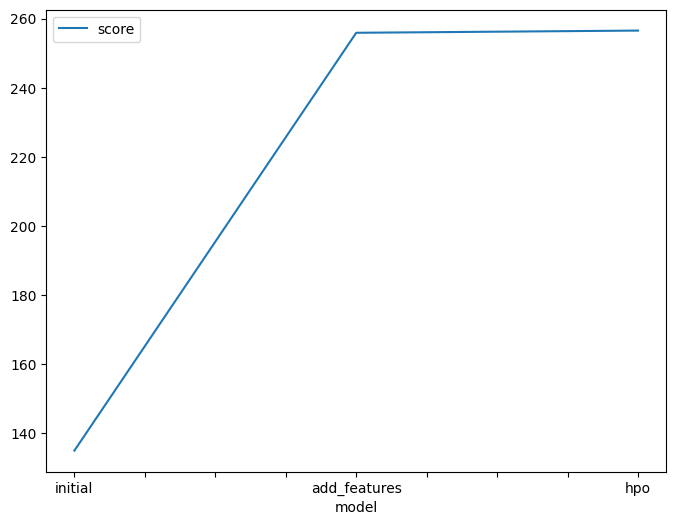

In [100]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [initial_score, add_features_score, hpo_score]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

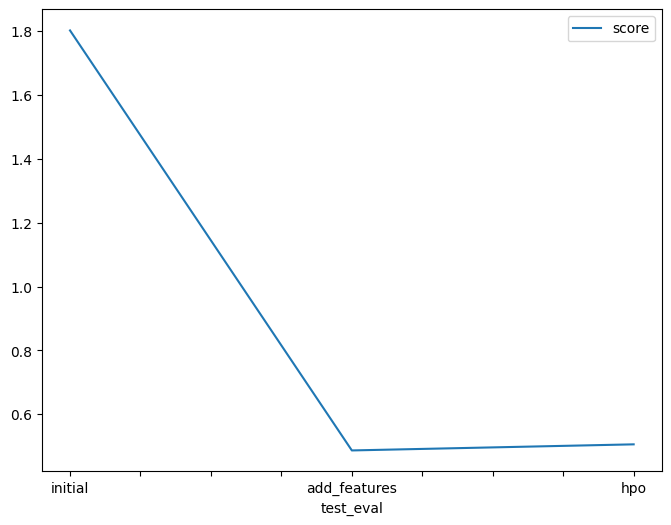

In [102]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80236, 0.48698, 0.50607]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [105]:
# The 3 hyperparameters we tuned with the kaggle score as the result
model_score = pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['default', 'default', xgb_options],
    "hpo2": ['default', 'default', cat_options],
    "hpo3": ['default', 'default', gbm_options],
    "score": [1.80795, 0.48986, 0.50607]
})
model_score

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.80795
1,add_features,default,default,default,0.48986
2,hpo,"{'n_estimators': Int: lower=100, upper=400, 'm...","{'iterations': 100, 'learning_rate': Real: low...","{'num_boost_round': 100, 'num_leaves': Int: lo...",0.50607


In [106]:
model_score.to_csv('model_score.csv')